In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchshow as ts
from datasets.nerf_synthetic import SubjectLoader
from matplotlib import pyplot as plt
from nerfacc.estimators.occ_grid import OccGridEstimator
from radiance_fields.ngp import NGPRadianceField
from typing import Any, Dict
from utils import render_image_with_occgrid_test

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

device = "cuda:0"

# dataset parameters
scene = "drums"
data_root = "/media/data7/fballerini/datasets/nerf_synthetic"
test_dataset_kwargs = {}
# scene parameters
aabb = torch.tensor([-1.5, -1.5, -1.5, 1.5, 1.5, 1.5], device=device)
near_plane = 0.0
far_plane = 1.0e10
# model parameters
grid_resolution = 128
grid_nlvl = 1
# render parameters
render_step_size = 5e-3
alpha_thre = 0.0
cone_angle = 0.0

test_dataset = SubjectLoader(
    subject_id=scene,
    root_fp=data_root,
    split="test",
    num_rays=None,
    device=device,
    **test_dataset_kwargs,
)

estimator = OccGridEstimator(roi_aabb=aabb, resolution=grid_resolution, levels=grid_nlvl).to(device)
radiance_field = NGPRadianceField(aabb=estimator.aabbs[-1], use_torch_encoding=True).to(device)

In [2]:
def render_test(state_dict: Dict[str, Any]) -> None:
    estimator.load_state_dict(state_dict["estimator"])
    radiance_field.load_state_dict(state_dict["radiance_field"])

    # evaluation
    radiance_field.eval()
    estimator.eval()

    with torch.no_grad():
        data = test_dataset[0]
        render_bkgd = data["color_bkgd"]
        rays = data["rays"]
        pixels = data["pixels"]

        # rendering
        rgb, _, _, _ = render_image_with_occgrid_test(
            1024,
            # scene
            radiance_field,
            estimator,
            rays,
            # rendering options
            near_plane=near_plane,
            render_step_size=render_step_size,
            render_bkgd=render_bkgd,
            cone_angle=cone_angle,
            alpha_thre=alpha_thre,
        )
        mse = F.mse_loss(rgb, pixels)
        psnr = -10.0 * torch.log(mse) / np.log(10.0)
        
        ts.show(rgb)
        return psnr.item()

$A,B$ same shape, diff init

$H$ = multi-resolution hash grid

$M$ = MLP (actually there are two, one for density and one for color)

$(H_A,M_A)$
---

29.27492332458496

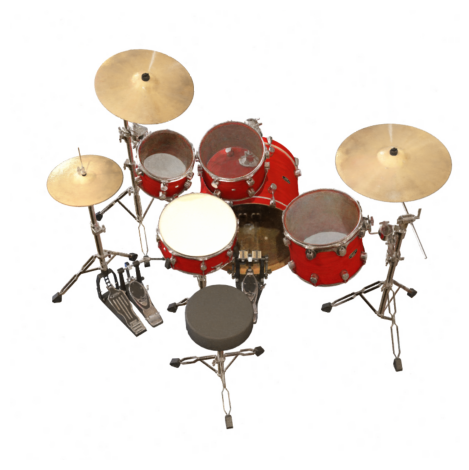

In [3]:
sd_A = torch.load("ckpts/drums_torch_A.pt")

render_test(sd_A)

$(H_B,M_B)$
---

29.252742767333984

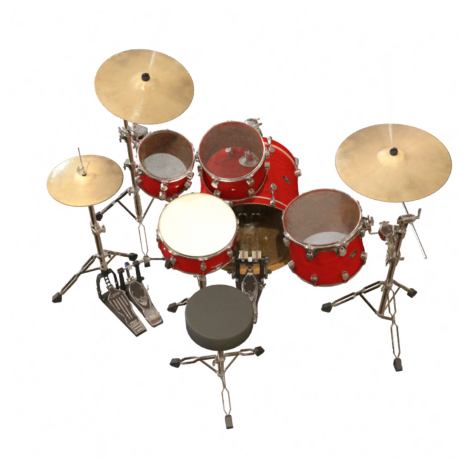

In [4]:
sd_B = torch.load("ckpts/drums_torch_B.pt")

render_test(sd_B)

$(H_A,M_B)$
---

11.182065963745117

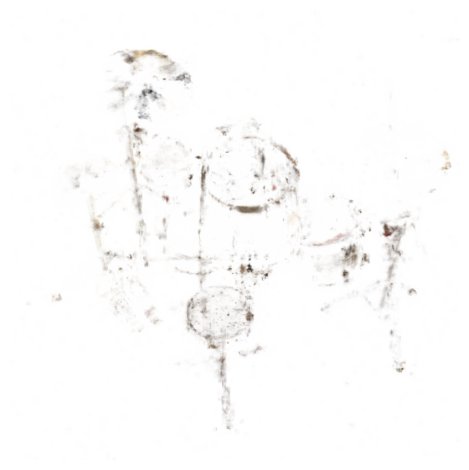

In [5]:
sd_A = torch.load("ckpts/drums_torch_A.pt")
sd_B = torch.load("ckpts/drums_torch_B.pt")
sd_A["radiance_field"]["mlp_base.1.params"] = sd_B["radiance_field"]["mlp_base.1.params"]  # density mlp
sd_A["radiance_field"]["mlp_head.params"] = sd_B["radiance_field"]["mlp_head.params"]  # color mlp

render_test(sd_A)

$(H_A^\text{perm},M_B)$
---

12.416668891906738

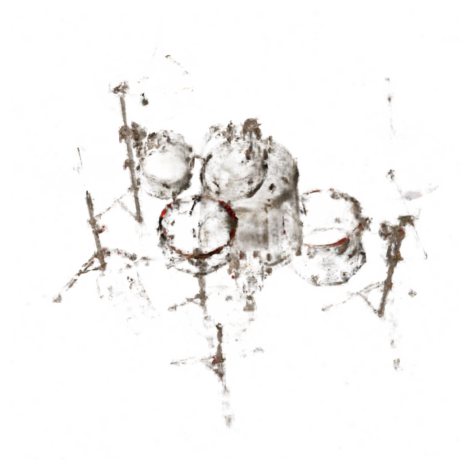

In [7]:
sd = torch.load("ckpts/drums_torch_perm.pt")

render_test(sd)

$A,A'$ same shape, same init

$(H_A, M_{A'})$
---

21.0594539642334

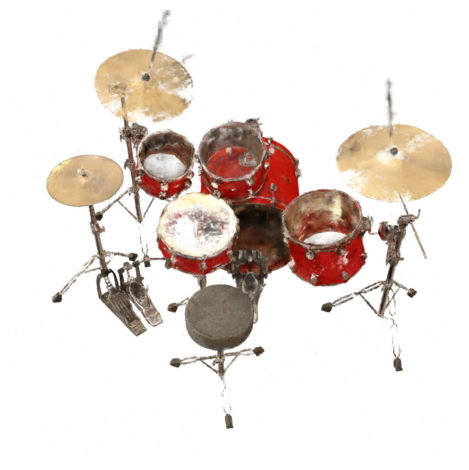

In [8]:
sd_A = torch.load("ckpts/drums_torch_A.pt")
sd_B = torch.load("ckpts/drums_torch_A2.pt")
sd_A["radiance_field"]["mlp_base.1.params"] = sd_B["radiance_field"]["mlp_base.1.params"]  # density mlp
sd_A["radiance_field"]["mlp_head.params"] = sd_B["radiance_field"]["mlp_head.params"]  # color mlp

render_test(sd_A)

What if $B$ is such that $\text{init}(H_B)=\text{init}(H_A)$ and $\text{init}(M_B)\neq\text{init}(M_A)$?

$(H_B,M_B)$
---

29.239913940429688

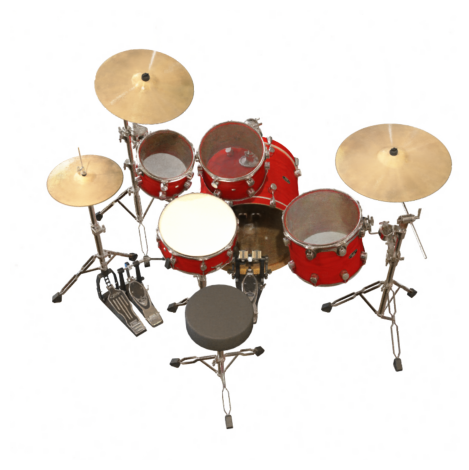

In [9]:
sd_B = torch.load("ckpts/drums_torch_hash_A_mlp_B.pt")

render_test(sd_B)

$(H_A,M_B)$
---

11.6387357711792

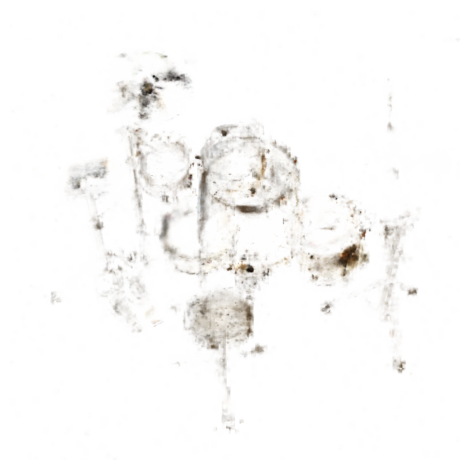

In [10]:
sd_A = torch.load("ckpts/drums_torch_A.pt")
sd_B = torch.load("ckpts/drums_torch_hash_A_mlp_B.pt")
sd_A["radiance_field"]["mlp_base.1.params"] = sd_B["radiance_field"]["mlp_base.1.params"]  # density mlp
sd_A["radiance_field"]["mlp_head.params"] = sd_B["radiance_field"]["mlp_head.params"]  # color mlp

render_test(sd_A)

$(H_A^\text{perm},M_B)$
---

12.766181945800781

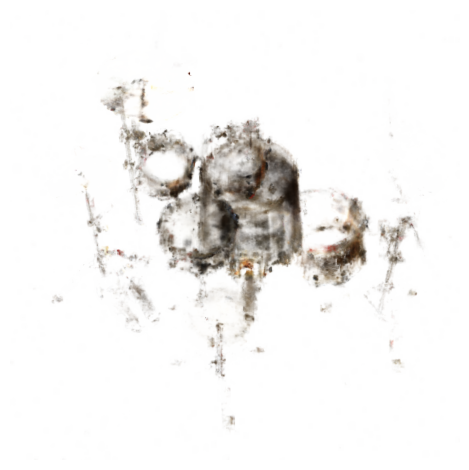

In [11]:
sd = torch.load("ckpts/drums_torch_perm_v2.pt")

render_test(sd)

In [ ]:
def plot_hist(sd_A: Dict[str, Any], sd_B: Dict[str, Any], level: int) -> None:
    grid_A = sd_A["radiance_field"][f"mlp_base.0.levels.{level}.embedding.weight"]
    grid_B = sd_B["radiance_field"][f"mlp_base.0.levels.{level}.embedding.weight"]

    vals_A = grid_A.flatten().cpu().numpy()
    vals_B = grid_B.flatten().cpu().numpy()

    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    ax[0].hist(vals_A, bins=100)
    ax[1].hist(vals_B, bins=100)
    ax[0].set_ylabel(f"Level {level}")
    ax[0].set_title(f"A")
    ax[1].set_title(f"B")

    fig.tight_layout()
    plt.show()


sd_A = torch.load("ckpts/drums_torch_A.pt")
sd_B = torch.load("ckpts/drums_torch_B.pt")
for l in range(15):
    plot_hist(sd_A, sd_B, l)